***
# <font color=#ff4013 size=10>Trabalho Final</font>
***

Universidade de Brasília/PPCA

Métodos Computacionais Intensivos para Mineração de Dados

Prof. Guilherme Souza Rodrigues

José Ronaldo Agra de Souza Filho - 22/0005427
Paulo Célio Soares da Silva Júnior - 22/0005605

**Importando bibliotecas.**

In [1]:
from scipy.spatial import distance
import numpy as np
import pandas as pd
import seaborn as sns
import ciw
import os

**Definindo constantes globais.**

In [2]:
# Valor da semente padrão
SEED = 42
# Quantidade de filas a serem geradas
M = 10000
# Arquivo para armazenar a simulação que cria 1 fila com 2 atendentes (atendimento concorrente)
ARQUIVO_FILAS_ATEND_CONCORRENTE = "filas_atendimento_concorrente.csv"
# Arquivo para armazenar a simulação que cria 2 filas com 1 atendente (atendimento paralelo)
ARQUIVO_FILAS_ATEND_PARALELO = "filas_atendimento_paralelo.csv"

**Definindo as funções para criação de filas a partir de parâmetros $\lambda$ e $\mu$.**

In [3]:
def probabilidade_de_desistencia(tam_fila):
    """
    Função para indicar a probabilidade de desistência de uma pessoa, de acordo com o tamanho da fila.
    :param tam_fila: O tamanho da fila.
    :return: Uma probabilidade de desistência, variando de 0 a 1.
    """
    if tam_fila < 23:
        return 0.0

    if tam_fila < 45:
        return 0.5

    if tam_fila < 67:
        return 0.8

    return 1.0

In [4]:
def cria_simulacao(lam, mu, modo=None, seed=None):
    """
    Função para gerar uma fila simulada com base nos parâmetros específicados.
    :param lam: O lambda para a distribuição de tempo das chegadas.
    :param mu: O mu para a distribuição de tempo dos atendimentos.
    :param modo: Indica o modo da fila. Caso nada seja especificado, a simulação é criada como fila única. Para o valor 'filadupla' é criada uma fila dupla e para o valor 'desistencia' é criada uma fila simples, mas é passada como parâmetro uma função de probabilidade de desistência. Padrão = None.
    :param seed: A semente utilizada na geração dos estatisticas aleatórios. Padrão = None.
    :return: Um dataframe, com os estatisticas da fila gerada. O dataframe possuie as seguintes colunas: chegadas,
            tempo_servico, partidas, tempo_espera, atendente, tam_fila, node. Se o modo for 'desistencia', também retorna uma lista com o as desistências coletadas.
    """
    # Cria uma rede M/M/2 com os parâmetros definidos a priori
    if modo == "filadupla":
        N = ciw.create_network(
            arrival_distributions=[ciw.dists.Exponential(rate=lam / 2),
                                   ciw.dists.Exponential(rate=lam / 2)],
            service_distributions=[ciw.dists.Exponential(rate=mu),
                                   ciw.dists.Exponential(rate=mu)],
            routing=[[0.0, 0.0],
                     [0.0, 0.0]],
            number_of_servers=[1, 1]
        )
    else:
        N = ciw.create_network(
            arrival_distributions=[ciw.dists.Exponential(rate=lam)],
            service_distributions=[ciw.dists.Exponential(rate=mu)],
            baulking_functions=[probabilidade_de_desistencia] if modo == "desistencia" else None,
            number_of_servers=[2]
        )

    # Define uma semente
    ciw.seed(seed)
    # Cria uma simulação
    Q = ciw.Simulation(N)
    # Roda a simulação até o máximo de clientes atendidos por dia (n = 200)
    Q.simulate_until_max_customers(200)

    # Pega os registros de atendimento e gera dataframe
    registros = Q.get_all_records()
    chegadas = []
    partidas = []
    tempo_servico = []
    tempo_espera = []
    atendente = []
    tam_fila = []
    node = []

    for registro in registros:
        chegadas.append(registro.arrival_date)
        tempo_servico.append(registro.service_time)
        partidas.append(registro.exit_date)
        tempo_espera.append(registro.waiting_time)
        atendente.append(registro.server_id)
        tam_fila.append(registro.queue_size_at_arrival)
        node.append(registro.node)

    # Cria o dataframe
    fila = pd.DataFrame(zip(chegadas, tempo_servico, partidas, tempo_espera, atendente, tam_fila, node),
                         columns=["chegadas", "tempo_servico", "partidas", "tempo_espera", "atendente",
                                  "tam_fila", "node"])
    # Ordena, por ordem de chegadas, e calcula a diferença entre as chegadas
    fila.sort_values("chegadas", inplace=True)
    fila["tempo_entre_chegadas"] = fila.chegadas.diff()
    fila.fillna(0, inplace=True)

    # Para a opção de fila SEM desistência, retornamos apenas a fila. Para a opção de fila COM possibilidade de
    # desistência, retornamos a quantidade de desistências. Para este último caso, e como não definimos
    # classes de prioridade na fila, sempre teremos nó==1 e classe=0. Assim podemos fazer o acesso direto.
    if modo == "desistencia":
        return fila, len(Q.baulked_dict[1][0])

    return fila

---

## <font color=#008cb4>Contexto</font>

---


"*A teoria das filas é um ramo da probabilidade que estuda a formação de filas, através de análises matemáticas precisas e propriedades mensuráveis das filas.*" (Wikipedia)

---

## <font color=#008cb4>Problema</font>

---

Considere uma fila do tipo M/M/2 (veja o artigo citado abaixo ou qualquer outra referência sobre Teoria de filas), com tempo entre chegadas distribuído por uma exponencial com parâmetro $\lambda$ e tempo de atendimento por uma exponencial com parâmetro $\mu$. Suponha que uma empresa atenda, no máximo, 200 clientes por dia, e que, em um dado dia, foi registrado tempo médio de espera na fila de duas horas e 30 minutos e comprimento médio da fila de 22 pessoas. Note que como os dados de cada cliente não foram disponibilizados, a verossimilhança não pode ser calculada facilmente. Faça um estudo de simulação para responder as perguntas elencadas a seguir.


---

## <font color=#008cb4>Material de estudo</font>

---

[https://arxiv.org/pdf/1703.02151.pdf](https://arxiv.org/pdf/1703.02151.pdf)

![Normal](queue.png)

---

## <font color=#008cb4>Questões de interesse</font>

---

### Usando Computação Bayesiana Aproximada (ABC), estime a distribuição a posteriori para os parâmetros $\lambda$ e $\mu$.

---

Rodando as simulações para M (= 10.000) dados sintéticos com os parâmetros definidos a priori.

In [5]:
# Define o array [tempo_medio_espera, tamanho_medio_fila] a partir da observação
valores_obs = [150, 22]     # tempo médio = 150 min, e tamanho_medio = 22 pessoas

# Gera amostras aleatórias de λ e μ a partir da distribuição a priori
np.random.seed(SEED)
lam = np.random.uniform(size=M)
mu = np.random.uniform(high=0.5, size=M)

# Gera um arquivo csv com as estatísticas das simulações para economia de tempo de processamento
# Verifica se o arquivo já existe
if not os.path.exists(ARQUIVO_FILAS_ATEND_CONCORRENTE):
    # Inicializa uma lista vazia que armazenará as estatísticas das amostras geradas pelos parâmetros (lambda e mu)
    estatisticas = []

    # Executa uma simulação para a geração das filas
    # Executa o loop de iteração para estimar a distribuição a posteriori de λ e μ
    for i in range(M):
        # Gera estatisticas simulados a partir do modelo de distribuição exponencial com os parâmetros λ e μ
        fila = cria_simulacao(lam[i], mu[i], seed=SEED)
        # Os valores simulados para a fila gerada
        valores_sim = [fila.tempo_espera.mean(), fila.tam_fila.mean()]
        # Calcula a distância entre os estatisticas simulados e os estatisticas reais
        estatisticas.append([lam[i], mu[i], *valores_sim, distance.euclidean(valores_sim, valores_obs)])

    # Grava o dataframe em arquivo
    pd.DataFrame(estatisticas, columns=["lambda", "mu", "tempo_medio_espera", "tam_medio_fila", "distancia"]).to_csv(ARQUIVO_FILAS_ATEND_CONCORRENTE, encoding="utf-8", index=False)

Gerando o dataframe com as estatísticas.

In [6]:
# Carrega o dataframe Pandas com os parâmetros e as estatísticas calculadas
estatisticas_priori = pd.read_csv(ARQUIVO_FILAS_ATEND_CONCORRENTE)

# Recupera os 1% registros que tiveram as menores distâncias
indices_aceitos = estatisticas_priori.nsmallest(int(M * 0.01), "distancia").index
estatisticas_priori["aceito"] = estatisticas_priori.index.map(lambda x: 1 if x in indices_aceitos else 0)

<font color='red'>**Resposta:**</font>

O intervalo de credibilidade (95%) e o gráfico a seguir mostram as distribuições a posteriori para os parâmetros $\lambda$ e $\mu$ respectivamente. Para a resolução da questão, foram avaliadas duas distâncias: euclidiana e de Mahalanobis. Por mostrar menor variabilidade em relação aos valores do tempo médio de espera e tamanho médio da fila, a primeira foi escolhida em detrimento da segunda. Dada a característica das observações do tempo médio de espera e tamanho médio de fila, assumiu-se como parâmetros a priori para $\lambda$ e $\mu$ valores entre 0 e 1 para o primeiro e 0 e 0,5 para o segundo, considerando-se que taxa de chegada é maior do que a taxa de atendimento. Após as simulações, parâmetros $\lambda$ e $\mu$ que não geraram dados sintéticos de filas parecidos com os dados observados foram rejeitados (aceito = 0) e aqueles que geram filas similares foram aceitos (aceito = 1). O gráfico ilustra a região de aceitação com pontos na cor laranja e os demais pontos rejeitados na cor azul.

Definindo o intervalo de credibilidade de 95% dos parâmetros $\lambda$ e $\mu$.

In [7]:
print("Intervalo de credibilidade:")
estatisticas_priori.query("aceito == 1").filter(["lambda", "mu"]).quantile([0.025, 0.975])

Intervalo de credibilidade:


,lambda,mu
0.025,0.120832,0.058899
0.975,0.671229,0.165078


Plota o gráfico para visualização dos parâmetros $\lambda$ e $\mu$ aceitos e rejeitados.

<AxesSubplot: xlabel='lambda', ylabel='mu'>

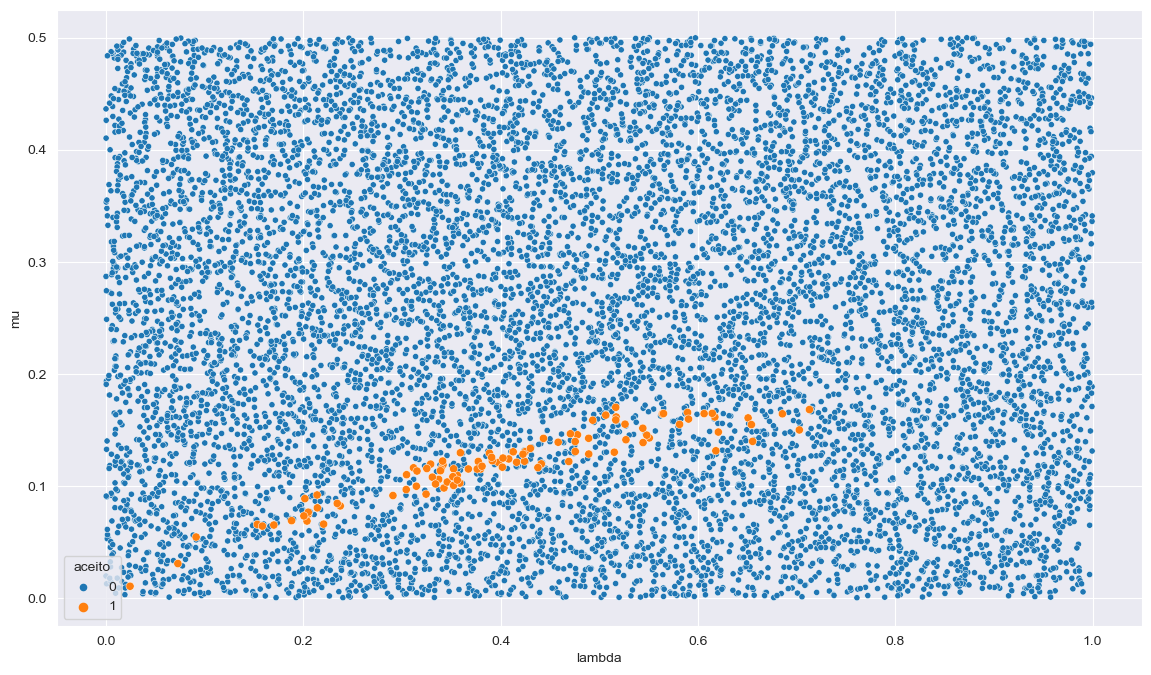

In [8]:
ax = sns.scatterplot(data=estatisticas_priori.sort_values("aceito"), x="lambda", y="mu", hue="aceito", size="aceito", sizes={0: 20, 1: 35})
ax.figure.set_size_inches(14, 8)
ax

### Teste a hipótese nula de que o tempo médio de atendimento é inferior à metade do tempo médio entre chegadas.

---

Gerando as estatísticas com os parâmetros obtidos a posteriori que serão utilizadas nesta e na próxima questão.

In [9]:
# Inicializa uma lista vazia que armazenará as estatísticas das amostras geradas pelos parâmetros (lambda e mu)
estatisticas = []

# Executa o loop de iteração para estimar a distribuição a posteriori de λ e μ
for estatistica in estatisticas_priori.query("aceito == 1").filter(["lambda", "mu"]).values:
    # Gera estatisticas simulados a partir do modelo de distribuição exponencial com os parâmetros λ e μ
    fila = cria_simulacao(estatistica[0], estatistica[1], seed=SEED)
    # Calcula as estatísticas relacionadas aos parâmetros a posteriori
    estatisticas.append([estatistica[0], estatistica[1], fila.tempo_servico.mean(), fila.tempo_entre_chegadas.mean(), fila.tam_fila.quantile(0.9), fila.tempo_espera.mean()])

Calculando a metade do tempo médio entre chegadas e o intervalo de credibilidade.

In [10]:
# Gera um dataframe Pandas as estatísticas calculadas
estatisticas_posteriori = pd.DataFrame(estatisticas, columns=["lambda", "mu", "tempo_medio_servico", "tempo_medio_entre_chegadas", "tam_fila_quantil_90", "tempo_medio_espera"])

print("Metade do tempo médio entre chegadas:", estatisticas_posteriori["tempo_medio_entre_chegadas"].mean() / 2)
print("Intervalo de credibilidade:")
estatisticas_posteriori["tempo_medio_servico"].quantile([0.025, 0.975])

Metade do tempo médio entre chegadas: 1.8303850409964242
Intervalo de credibilidade:


0.025     6.238622
0.975    18.462327
Name: tempo_medio_servico, dtype: float64

Exibindo o gráfico para a visualização dos dados.

<AxesSubplot: xlabel='tempo_medio_servico', ylabel='Density'>

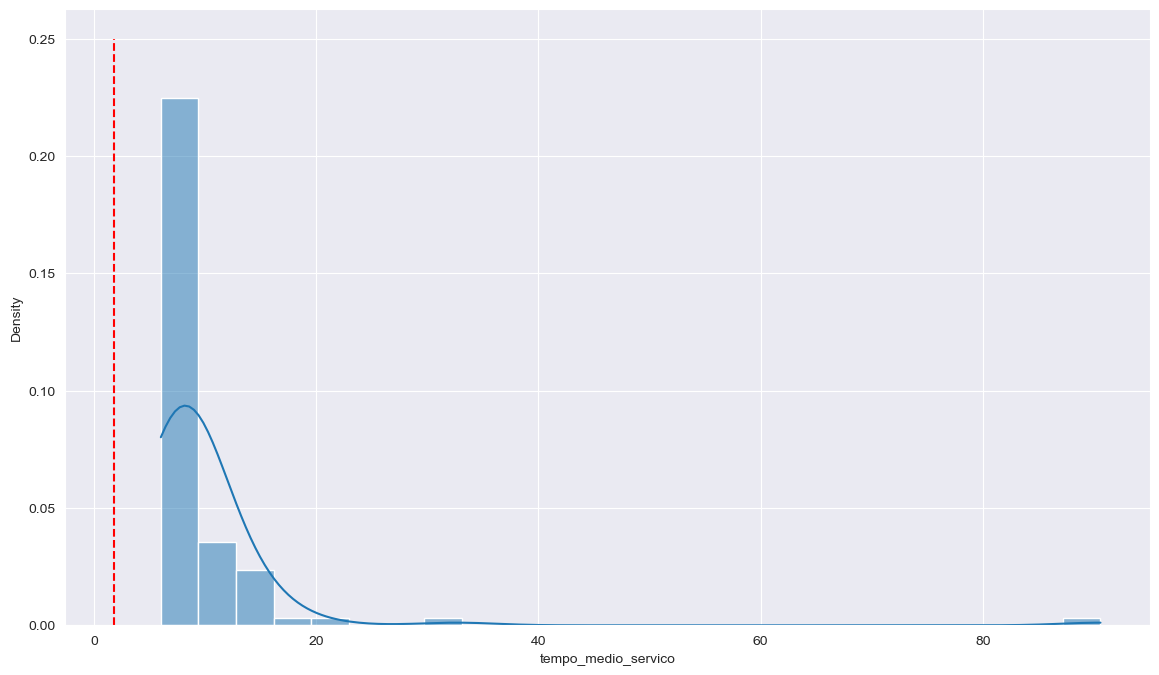

In [11]:
ax = sns.histplot(estatisticas_posteriori["tempo_medio_servico"], kde=True, stat="density", bins=25)
ax.figure.set_size_inches(14, 8)
ax.vlines(x=(estatisticas_posteriori["tempo_medio_entre_chegadas"].mean() / 2), ymin=0, ymax=0.25, colors="red", linestyles="dashed")
ax

<font color='red'>**Resposta:**</font>

Considerando-se o intervalo de credibilidade de 95%, bem como a análise gráfica, pode-se descartar a hipótese nula ($H_{0}$) de que tempo médio de atendimento é inferior à metade do tempo médio entre chegadas. Com os dados da simulação, na verdade, infere-se que chegam pessoas mais rapidamente do que a capacidade de atendimento. Pela análise numérica, já daria para rejeitar a hipótese nula, dado que a metade do tempo médio entre chegadas, que corresponde a 1,8304 chegadas/minutos, é inferior ao tempo médio de atendimento, que, no intervalo de credibilidade, ficou entre 6,2386 e 18,4623. No gráfico, a linha tracejada vermelha corresponde ao valor da metade do tempo médio entre chegadas e o histograma corresponde à distribuição de frequência dos tempos médios de serviço obtidos a partir dos dados sintéticos simulados.

### Caso o hospital deseje que em $90\%$ do tempo todos os pacientes na fila possam se sentar simultaneamente, quantas cadeiras seriam necessárias? Dica: para cada amostra da posteriori, simule uma fila e calcule a estatística desejada. Em seguida, construa um intervalo de credibilidade.

---

Exibindo a média dos quantis 90% dos tamanos das filas e o intervalo de credibilidade.

In [12]:
print("Média dos quantis 90% dos tamanhos das filas:", estatisticas_posteriori['tam_fila_quantil_90'].mean())
print("Intervalo de credibilidade:")
estatisticas_posteriori["tam_fila_quantil_90"].quantile([0.025, 0.975])

Média dos quantis 90% dos tamanhos das filas: 61.457000000000015
Intervalo de credibilidade:


0.025    27.5225
0.975    85.6250
Name: tam_fila_quantil_90, dtype: float64

<font color='red'>**Resposta:**</font>

A partir da simulação com os parâmetros a posteriori, encontrados à luz dos dados observados, pode-se afirmar que seriam necessárias 86 cadeiras para que todos os pacientes na fila pudessem se sentar simultaneamente durante 90% do tempo, considerando o intervalo de credibilidade de 95%. O valor aqui exposto foi arredondado para o número inteiro imediatamente superior, uma vez que não existe fracionamento de cadeiras.

### Avalie se o tempo de espera reduziria caso houvesse duas filas de atendimento independentes (considerando os mesmos parâmetros estimados anteriormente - veja a figura acima).

---

Gerando as estatísticas com os parâmetros obtidos a posteriori, considerando uma fila dupla.

In [13]:
# Calcula o tempo médio de espera da fila simples
tempo_medio_espera_fila_simples = estatisticas_posteriori["tempo_medio_espera"].mean()
tempo_medio_espera_fila_dupla = []
# Calcula o tempo médio de espera da fila dupla (atendimentos independentes)
for estatistica in estatisticas_posteriori.filter(["lambda", "mu"]).values:
    fila = cria_simulacao(estatistica[0], estatistica[1], modo="filadupla", seed=SEED)
    tempo_medio_espera_fila_dupla.append(fila.tempo_espera.mean())

In [14]:
print("Tempo médio de espera com fila simples:", tempo_medio_espera_fila_simples)
print("Tempo médio de espera com fila dupla:", np.mean(tempo_medio_espera_fila_dupla))
print(f"Acréscimo no tempo médio de espera: {round(((np.mean(tempo_medio_espera_fila_dupla) / tempo_medio_espera_fila_simples) - 1) * 100, 2)}%")

Tempo médio de espera com fila simples: 147.84535689864077
Tempo médio de espera com fila dupla: 206.0715154416711
Acréscimo no tempo médio de espera: 39.38%


<font color='red'>**Resposta:**</font>

De acordo com a simulação, considerando-se os parâmetros estimados a posteriori, verificou-se que não há redução no tempo de espera com a mudança para um modelo de filas independentes. Pelo contrário, a mudança no modelo ocasionou um aumento do tempo médio de espera de 39,38% aproximadamente.

### O tamanho da fila é um desestímulo aos pacientes. Ao ver uma fila grande, o paciente desiste do atendimento com certa probabilidade. Incorpore essa característica à sua simulação e estime quantas pessoas desestiram do atendimento no dia em que os dados foram coletados. Essa é uma atividade desafiadora! Justifique suas suposições.

---

In [15]:
# Gera um arquivo csv com as estatísticas das simulações para economia de tempo de processamento
# Verifica se o arquivo já existe
if not os.path.exists(ARQUIVO_FILAS_ATEND_PARALELO):
    # Inicializa uma lista vazia que armazenará as estatísticas das amostras geradas pelos parâmetros (lambda e mu)
    estatisticas = []

    # Executa o loop de iteração para estimar a distribuição a posteriori de λ e μ
    for i in range(M):
        # Gera estatisticas simulados a partir do modelo de distribuição exponencial com os parâmetros λ e μ
        fila, desistencias = cria_simulacao(lam[i], mu[i], modo="desistencia", seed=SEED)
        # Os valores simulados para a fila gerada
        valores_sim = [fila.tempo_espera.mean(), fila.tam_fila.mean()]
        # Calcula a distância entre os estatisticas simulados e os estatisticas reais
        estatisticas.append([lam[i], mu[i], *valores_sim, distance.euclidean(valores_sim, valores_obs), desistencias])

    # Grava o dataframe em arquivo
    pd.DataFrame(estatisticas, columns=["lambda", "mu", "tempo_medio_espera", "tam_medio_fila", "distancia", "desistencias"]).to_csv(ARQUIVO_FILAS_ATEND_PARALELO, encoding="utf-8", index=False)

In [16]:
# Carrega o dataframe Pandas com os parâmetros e as estatísticas calculadas
estatisticas_priori = pd.read_csv(ARQUIVO_FILAS_ATEND_PARALELO)

# Recupera os 1% registros que tiveram as menores distâncias
indices_aceitos = estatisticas_priori.nsmallest(int(M * 0.01), "distancia").index
estatisticas_priori["aceito"] = estatisticas_priori.index.map(lambda x: 1 if x in indices_aceitos else 0)

estatisticas_posteriori = estatisticas_priori.query("aceito == 1")
# Calcula a média e os quantis das desistências
print("Menor número de desistências:", estatisticas_posteriori["desistencias"].min())
print("Média de desistências:", estatisticas_posteriori["desistencias"].mean())
print("Intervalo de credibilidade:")
estatisticas_posteriori["desistencias"].quantile([0.025, 0.975])

Menor número de desistências: 56
Média de desistências: 244.8
Intervalo de credibilidade:


0.025    108.950
0.975    442.825
Name: desistencias, dtype: float64

<font color='red'>**Resposta:**</font>

Para esta questão, criamos suposições sobre a probabilidade de desistência de uma pessoa ao chegar no hospital e se deparar com uma fila grande. Consideramos que a motivação que leva uma pessoa a um hospital é relacionada a algum nível de incômodo, com variado nível de urgência. Logo, a tolerância em relação ao tempo de espera é maior que em outras situações (p.ex. filas de banco ou de restaurantes).

No nosso contexto, entendemos ser aceitável uma pessoa decidir esperar o atendimento, em 100% dos casos, quando a fila tiver com tamanho médio de até 22 (valor da observação). Entretanto, quanto mais aumenta a fila, maior a probabilidade das pessoas que chegam ao hospital desistirem da espera. Assim sendo, definimos que a probabilidade de desistência está relacionada ao tamanho médio da fila na seguinte relação:

- Tamanho da fila até 22: probabilidade de desistência é de 0%;
- Tamanho da fila entre 23 e 44 (o dobro do tamanho médio da fila observado): probabilidade de desistência é de 50%;
- Tamanho da fila entre 45 e 66 (o triplo do tamanho médio da fila observado): probabilidade de desistência é de 80%;
- Tamanho da fila maior do que 66: probabilidade de desistência é de 100%.

Neste cenário, incorporamos essa característica à nossa simulação e verificamos que, em média, por volta de 244,8 pessoas desistiram do atendimento no dia em que os dados foram coletados (ou seja, na nossa simulação), com intervalo de credibilidade de 95%, variando entre 108,95 e 442,83 desistências. Isso nos levou a acreditar que o modelo de fila adotado no hospital é extremamente ineficiente, dado o número de pessoas que desistem ao longo do dia ser alto, mesmo no melhor dos casos (56 desistências).